<a href="https://colab.research.google.com/github/amazingsmash/Heightmap_Feature_Segmentation/blob/master/Heightmap_Feature_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

The test data for this test has been generated at other of my repos https://github.com/amazingsmash/las_image_segmentation.git .
The data there contains images generated from airborn lidar scans of power lines. In this notebook we intend to segment the turrets from the rest of elements.

In [0]:
!rm -r las_image_segmentation
!mkdir test_results
!mkdir img_train_generated
!git clone https://github.com/amazingsmash/las_image_segmentation.git

images_dir = 'las_image_segmentation/upperView_0.2/images'
labels_dir = 'las_image_segmentation/upperView_0.2/labels'
test_images_dir = 'las_image_segmentation/upperView_0.2/test_images'

#This file should contain a "feat_image" multifeature heightmap and a "mask" image
heightmap_matfile = "PATH TO YOUR DATA .MAT" 


rm: cannot remove 'las_image_segmentation': No such file or directory
Cloning into 'unet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 44.92 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Cloning into 'las_image_segmentation'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 308 (delta 0), reused 2 (delta 0), pack-reused 299
Receiving objects: 100% (308/308), 49.39 MiB | 20.02 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [0]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import glob, os
from matplotlib import pyplot as plt
import scipy.io

Using TensorFlow backend.


###Tools

In [0]:
def show_image(image):
  plt.imshow(image, interpolation='nearest')
  plt.show()
  
def add_padding_zeros(image, size):
  s = image.shape
  if image.shape != size:
    image_2 = np.pad(image, ((0,size[0] - s[0]), 
                             (0,size[1] - s[1]), 
                             (0,0)), 
                   'constant', constant_values=((0,0),(0,0),(0,0)))
    return image_2
  else:
    return image

def read_images(folder, thresholding, target_size=(256, 256), max_n_images=0, show_images=False):
    """
    Read images from path/folder and returns them in a numpy stack matrix of the target size
    """ 

    files = [folder + "/" + f for f in os.listdir(folder) if f.endswith(".png")]
    files.sort()
    if max_n_images > 0: files = files[0:max_n_images]
    
    x = np.zeros((len(files), target_size[0], target_size[1], 1), dtype=float)

    for i, file in enumerate(files):
        #print(file)
        img = io.imread(file, as_gray=True)
        
        img = (255-img) / 255 if not thresholding else img < 0.5
        img = trans.resize(img, (*target_size, 1))
        x[i] = img
        
        if show_images:
          print(img.dtype)
          plt.imshow(img[:,:,0], interpolation='nearest')
          plt.show()

    return x

###UNet network architecture

In [0]:
#Implementation of UNet on Keras by https://github.com/zhixuhao/unet . 
#All due credit to him.

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size, name="Image_Input_Layer")
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid', name="Final_Conv_Layer")(conv9)

    model = Model(inputs= inputs, outputs= conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

#Training

**Training DNN with data generators**

Reduces memory footprint in GPU

In [0]:
# Training from generators
!mkdir las_image_segmentation/upperView_0.2/augmented
def img_mask_gen(path='las_image_segmentation/upperView_0.2',
                    images_subfolder='images',
                    mask_subfolder='labels',
                    img_size = (256,256),
                    batch_size = 10,
                    seed = 42):
  
  image_datagen = ImageDataGenerator()
  image_generator = image_datagen.flow_from_directory(
      path,
      classes = [images_subfolder],
      class_mode = None,
      color_mode = "grayscale",
      target_size = img_size,
      batch_size = batch_size,
      save_to_dir = "las_image_segmentation/upperView_0.2/augmented",
      save_prefix  = "Image_Augmented",
      seed = seed)

  mask_datagen = ImageDataGenerator()
  mask_generator = image_datagen.flow_from_directory(
      path,
      classes = [mask_subfolder],
      class_mode = None,
      color_mode = "grayscale",
      target_size = img_size,
      batch_size = batch_size,
      save_to_dir = "las_image_segmentation/upperView_0.2/augmented",
      save_prefix  = "Mask_Augmented",
      seed = seed)
  
  gen = zip(image_generator, mask_generator)
  for (img,mask) in gen:
    img = (255-img) / 255
    mask = mask < 0.5
    
    if False:
      nImages = img.shape[0]
      for i in range(0,nImages):
        fig = plt.figure() 
        sub = fig.add_subplot(1, 2, 1)
        sub.imshow(img[i,:,:,0], interpolation='nearest')
        sub = fig.add_subplot(1, 2, 2)
        sub.imshow(mask[i,:,:,0], interpolation='nearest')
      
    plt.show()
    
    yield (img,mask)
    
train_gen = img_mask_gen(path='las_image_segmentation/upperView_0.2',
                          images_subfolder='images',
                          mask_subfolder='labels')

test_gen = img_mask_gen(images_subfolder="test_images", mask_subfolder="test_mask")

model_gen = unet()
model_checkpoint = ModelCheckpoint('unet_turret.hdf5', monitor='loss',verbose=1, save_best_only=True)

model_gen.fit_generator(train_gen,
                        steps_per_epoch=500,
                        epochs=2,
                        callbacks=[model_checkpoint],
                       validation_data=test_gen,
                       validation_steps=1)




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/2
Found 16 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Found 16 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
500/500 [==============================] - 645s 1s/step - loss: 0.0218 - acc: 0.9956 - val_loss: 0.0056 - val_acc: 0.9986

Epoch 00001: loss improved from inf to 0.02229, saving model to unet_turret.hdf5
Epoch 2/2
500/500 [==============================] - 625s 1s/step - loss: 0.0048 - acc: 0.9991 - val_loss: 0.0052 - val_acc: 0.9982

Epoch 00002: loss improved from 0.02229 to 0.00481, saving model to unet_turret.hdf5


**Training DNN loading all images on GPU at start**

Better performance.



/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


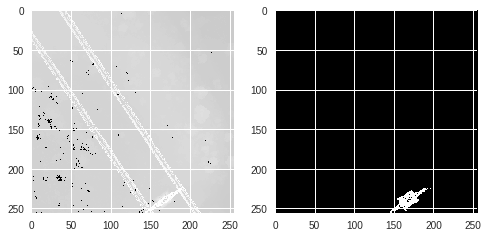

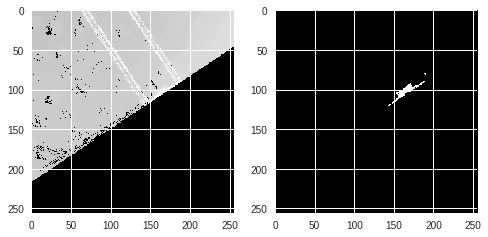

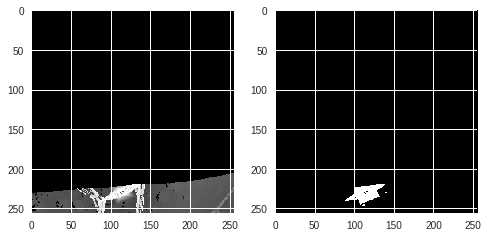

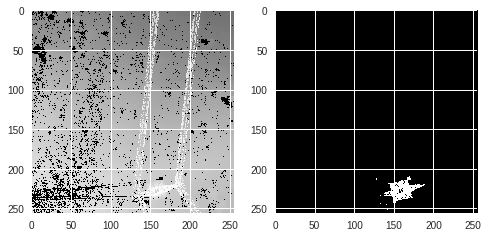

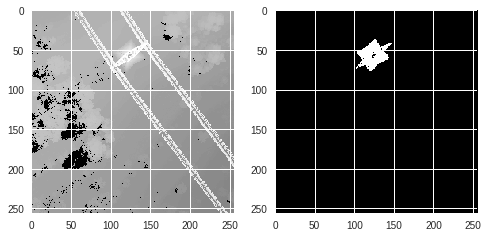

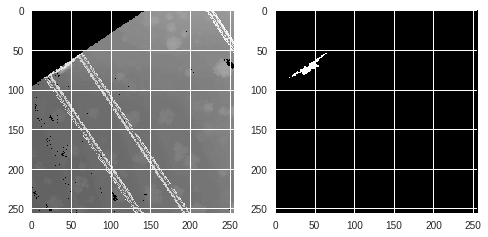

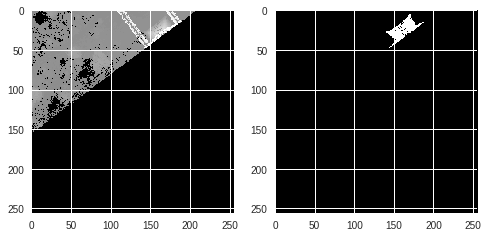

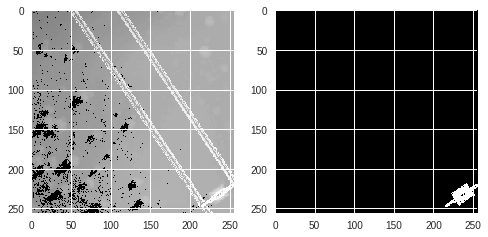

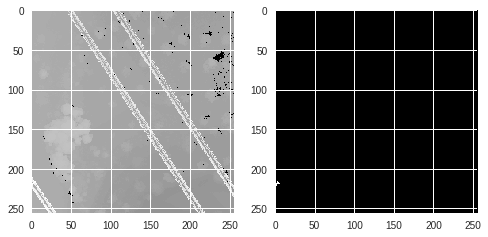

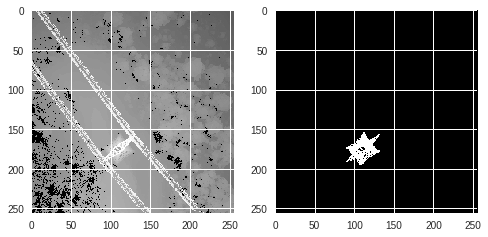

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/1
100/100 [==============================] - 159s 2s/step - loss: 0.1380 - acc: 0.9827

Epoch 00001: loss improved from inf to 0.13799, saving model to unet_turret.hdf5


In [0]:
# Try to introduce validation and test

def train_model():
    nImages = 10
    x = readImagesFromFolder(images_dir, thresholding=False, target_size=(256, 256), max_n_images=nImages, show_images=False)
    y = readImagesFromFolder(labels_dir, thresholding=True, target_size=(256, 256), max_n_images=nImages, show_images=False)
    # x, y = readImagesFromFiles('upperView_0.2', 'image', 'label')
    
    # print(np.min(y[0]))
    
    nImages = x.shape[0]
    for i in range(0,nImages):
      fig = plt.figure() 
      sub = fig.add_subplot(1, 2, 1)
      sub.imshow(x[i,:,:,0], interpolation='nearest')
      sub = fig.add_subplot(1, 2, 2)
      sub.imshow(y[i,:,:,0], interpolation='nearest')
    plt.show()

    model = unet()
    model_checkpoint = ModelCheckpoint('unet_turret.hdf5', monitor='loss', verbose=1, save_best_only=True)
    model.fit(x, y, steps_per_epoch=100, epochs=1, callbacks=[model_checkpoint])
    
    return model


model = train_model()

## Final Training

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


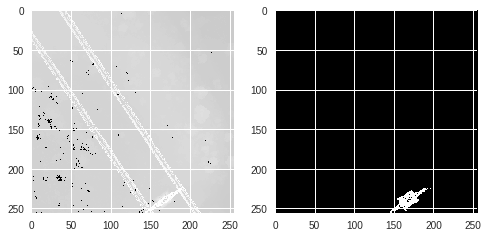

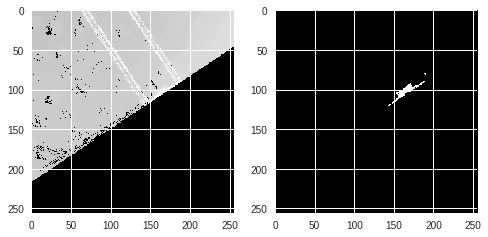

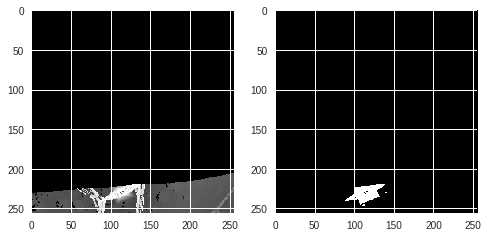

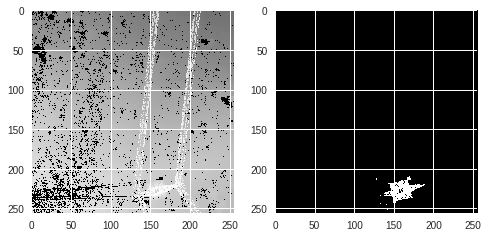

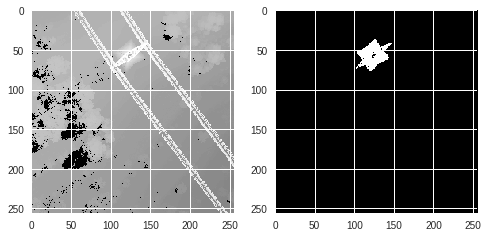

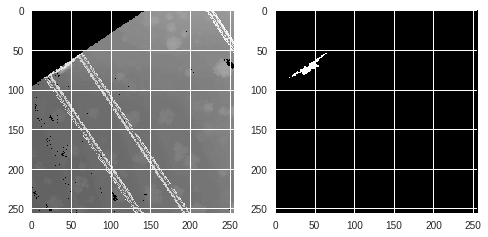

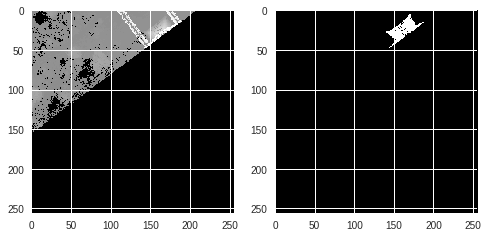

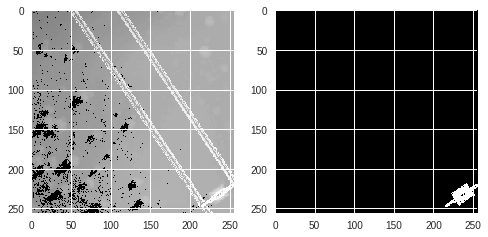

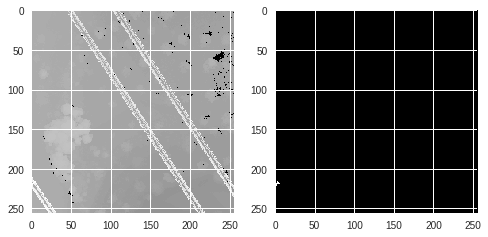

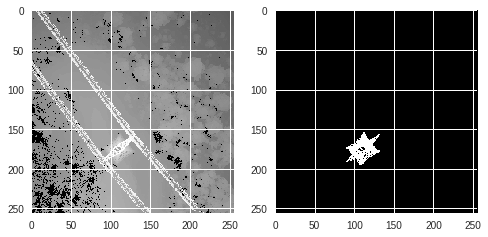

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/1
100/100 [==============================] - 148s 1s/step - loss: 0.0882 - acc: 0.9920

Epoch 00001: loss improved from inf to 0.08823, saving model to unet_turret.hdf5


In [0]:
def trainModel():
    nImages = 10
    x = read_images(images_dir, thresholding=False, target_size=(256, 256), max_n_images=nImages, show_images=False)
    y = read_images(labels_dir, thresholding=True, target_size=(256, 256), max_n_images=nImages, show_images=False)

    nImages = x.shape[0]
    for i in range(0,nImages):
      fig = plt.figure() 
      sub = fig.add_subplot(1, 2, 1)
      sub.imshow(x[i,:,:,0], interpolation='nearest')
      sub = fig.add_subplot(1, 2, 2)
      sub.imshow(y[i,:,:,0], interpolation='nearest')
    plt.show()

    model = unet()
    model_checkpoint = ModelCheckpoint('unet_turret.hdf5', monitor='loss', verbose=1, save_best_only=True)
    model.fit(x, y, steps_per_epoch=100, epochs=1, callbacks=[model_checkpoint])
    
    return model


model = trainModel()

  

**Generating images from big height map**




In [0]:
def image_from_mat_generator(image, mask, n_images_batch=10, tile_size=(256,256)):

  w = image.shape[0]
  h = image.shape[1]
  n_channels = 1
  
  tiles = np.zeros((n_images_batch, tile_size[0], tile_size[1], n_channels))
  masks = np.zeros((n_images_batch, tile_size[0], tile_size[1], 1))
  
  while True:
    x = (np.random.rand(n_images_batch) * (w - tile_size[0])).astype(int)
    y = (np.random.rand(n_images_batch) * (h - tile_size[1])).astype(int)
    
    for i in range(n_images_batch):
      tile = image[x[i]: x[i]+tile_size[0], 
                   y[i]: y[i]+tile_size[1], 
                   0:1]  #Just first channel now
      
      tile_mask = mask[x[i]:x[i]+tile_size[0], 
                       y[i]:y[i]+tile_size[1]]
      # print(tile_mask.shape)
      
      tiles[i,:,:] = tile.reshape((tile_size[0], tile_size[1], n_channels))
      masks[i,:,:] = tile_mask.reshape((tile_size[0], tile_size[1], 1))
      
      # print(np.unique(tile))
      # show_image(tile_mask.reshape((tile_size[0], tile_size[1])))
      
    # print(tiles.shape)
      
    yield (tiles, masks)
    
    
def image_from_mat_generator_balanced(image, mask, n_images_batch=10, tile_size=(256,256)):

  w = image.shape[0]
  h = image.shape[1]
  n_channels = 1
  
  tiles = np.zeros((n_images_batch, tile_size[0], tile_size[1], n_channels))
  masks = np.zeros((n_images_batch, tile_size[0], tile_size[1], 1))
  
  n_positives = 0
  
  while True:
    i = 0
    while i < n_images_batch:
      
      x = int(np.random.rand(1) * (w - tile_size[0]))
      y = int(np.random.rand(1) * (h - tile_size[1]))
    
      tile_mask = mask[x:x+tile_size[0], 
                       y:y+tile_size[1]]
      
      pos = np.sum(tile_mask) > 0
      if pos: 
        n_positives += 1 
      else: 
        n_positives += -1
      
      if n_positives < -1 or n_positives > 1: continue
        
        
      tile = image[x: x+tile_size[0], 
                   y: y+tile_size[1], 
                   0:1]  #Just first channel now
      
      
      # print(tile_mask.shape)
      
      tiles[i,:,:] = tile.reshape((tile_size[0], tile_size[1], n_channels))
      masks[i,:,:] = tile_mask.reshape((tile_size[0], tile_size[1], 1))
      i += 1
      
      # print(np.unique(tile))
      # show_image(tile_mask.reshape((tile_size[0], tile_size[1])))
      
    # print(tiles.shape)
      
    yield (tiles, masks)

#print(mat.keys())


mat = scipy.io.loadmat(heightmap_matfile)

feat_image = mat["feat_img"]
mask = mat["mask"]

image_from_mat_generator = image_from_mat_generator_balanced(image=feat_image, 
                                                    mask=mask)

model_gen = unet()
model_checkpoint = ModelCheckpoint('unet_turret.hdf5', monitor='loss',verbose=1, save_best_only=True)

model_gen.fit_generator(image_from_mat_generator,
                        steps_per_epoch=100,
                        epochs=2,
                        callbacks=[model_checkpoint],
                       class_weight=[1,500])
    
    

Epoch 1/2


#Visual testing of the model


In [0]:
#Segmentation generation function
def test_model(model, n_images=20):
    x = read_images(test_images_dir, thresholding=False, target_size=(256, 256), max_n_images=n_images, show_images=False)
    p = model.predict(x)
    
    nImages = x.shape[0]
    for i in range(0,nImages):
      fig = plt.figure() 
      sub = fig.add_subplot(1, 2, 1)
      
      sub.set_title('Image %d' % i)
      sub.imshow(x[i,:,:,0], interpolation='nearest')
      sub = fig.add_subplot(1, 2, 2)
      
      sub.imshow(p[i,:,:,0], interpolation='nearest')

    plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


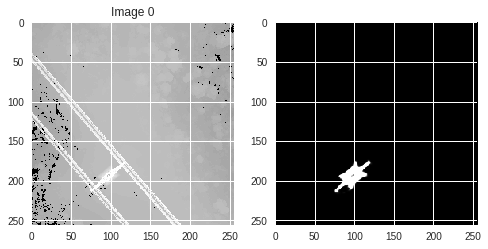

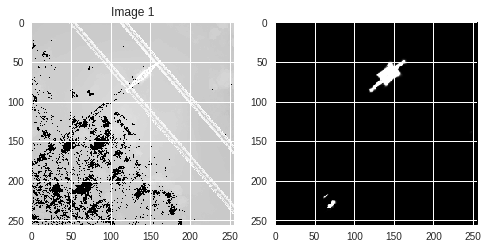

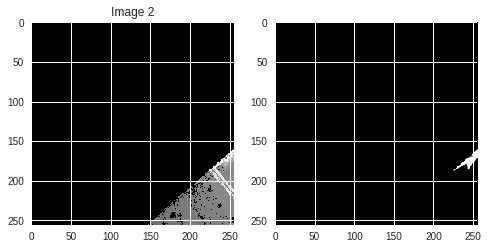

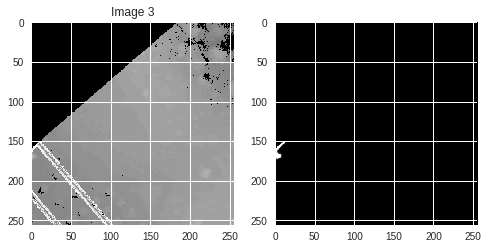

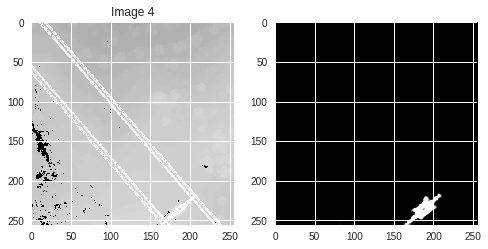

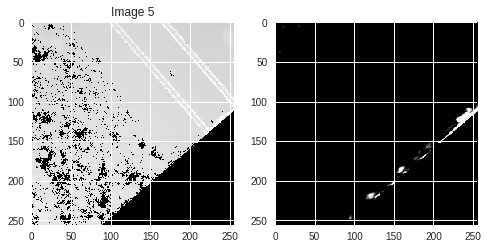

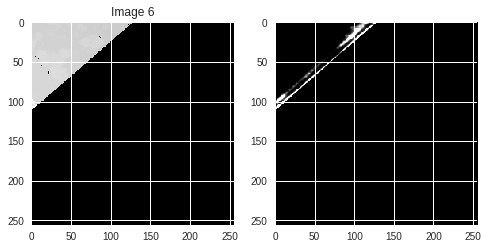

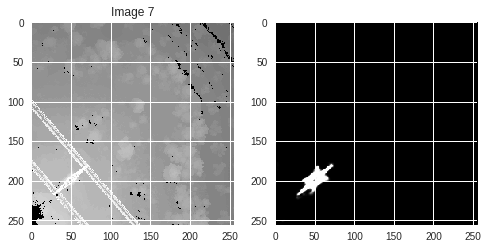

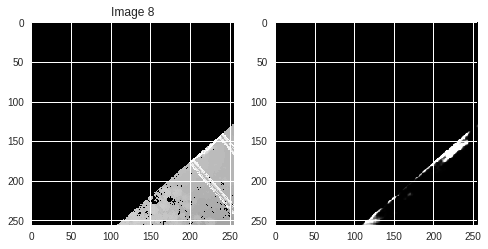

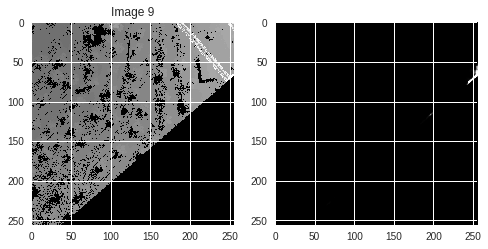

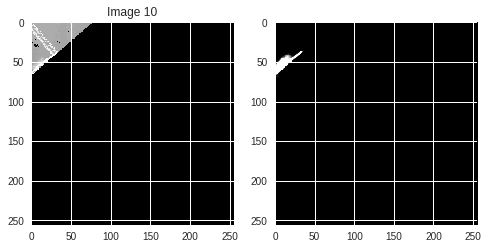

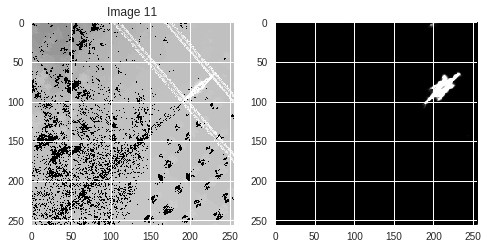

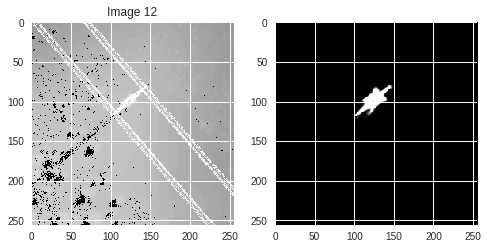

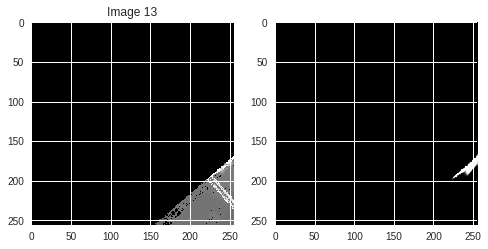

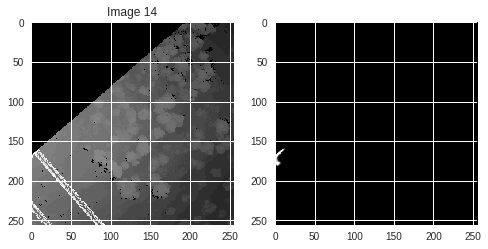

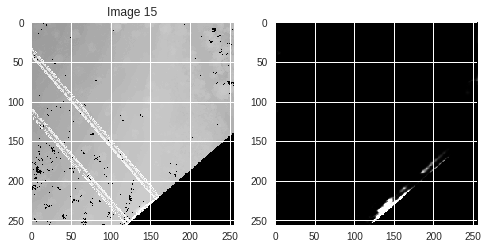

In [0]:
test_model(model=model_gen, n_images=20)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


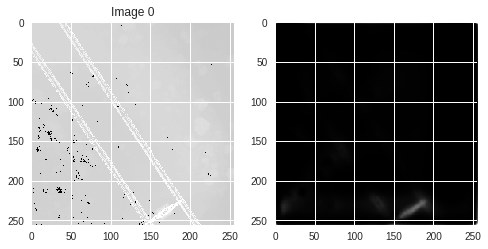

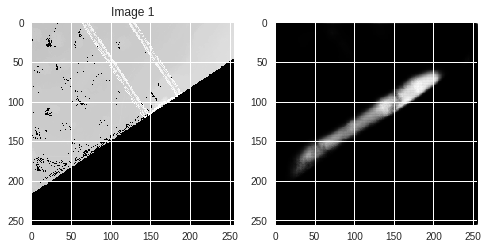

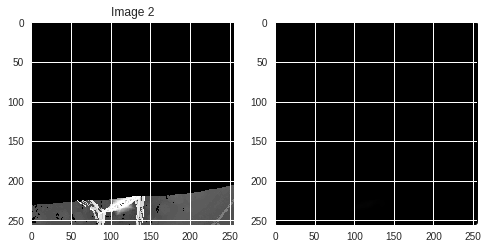

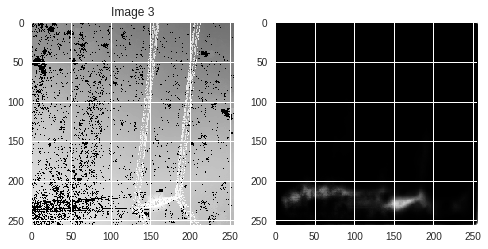

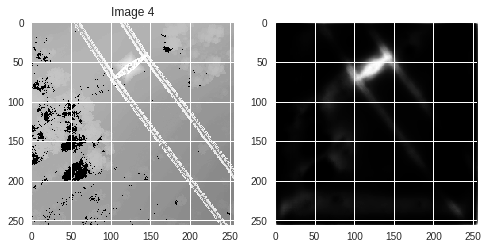

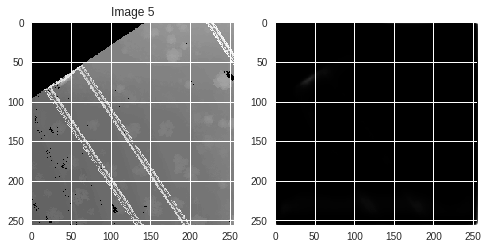

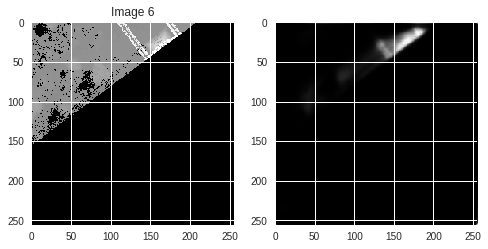

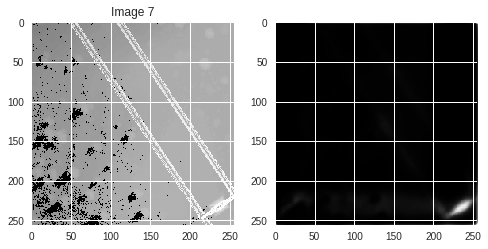

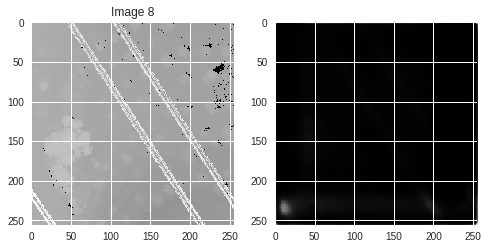

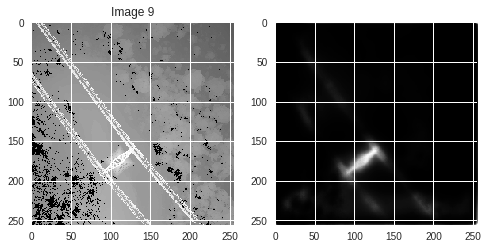

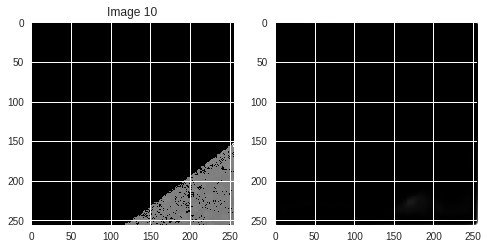

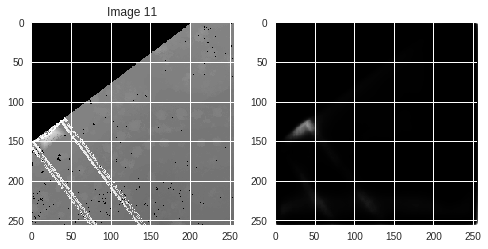

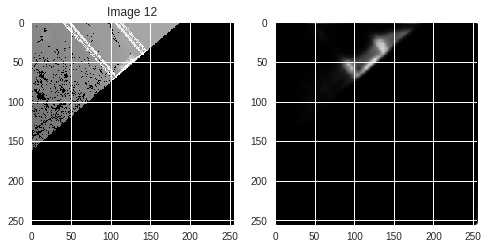

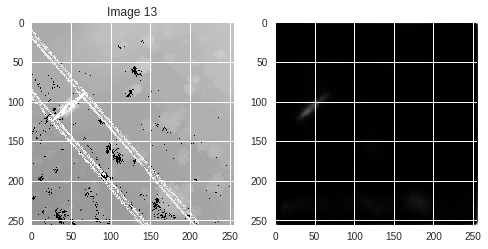

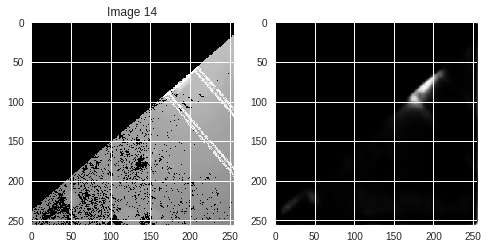

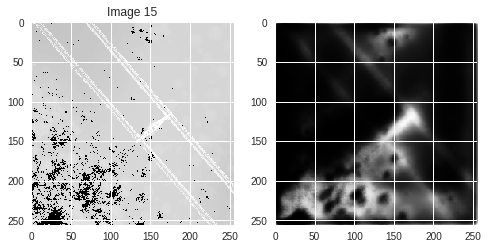

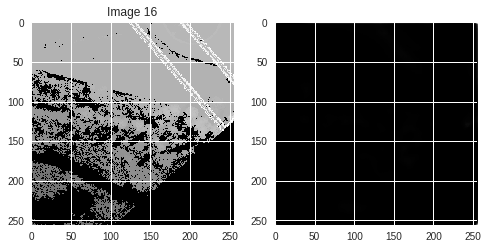

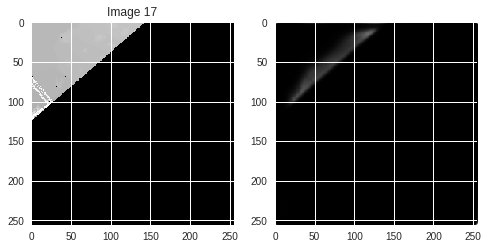

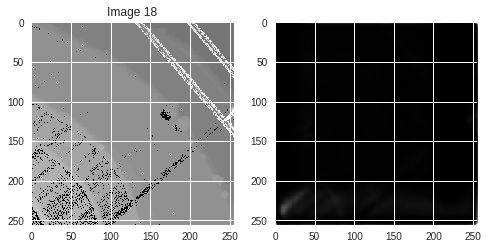

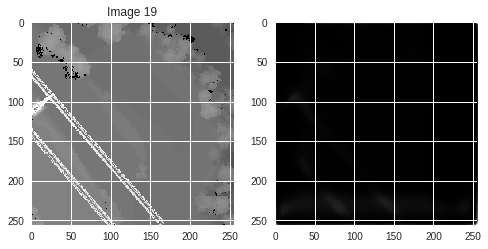

In [0]:
model = unet(pretrained_weights="unet_turret.hdf5",input_size = (256,256,1))
test_model(model, n_images=20)

**Sharp results**

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


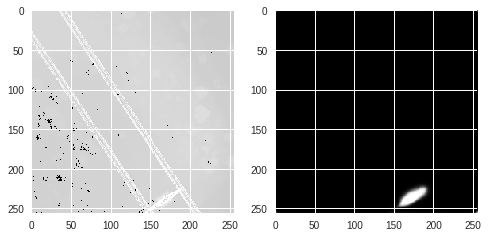

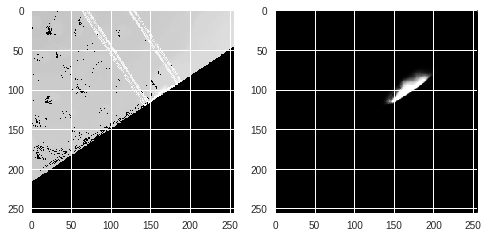

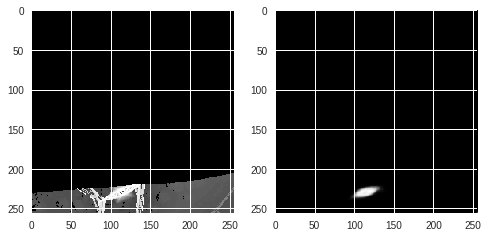

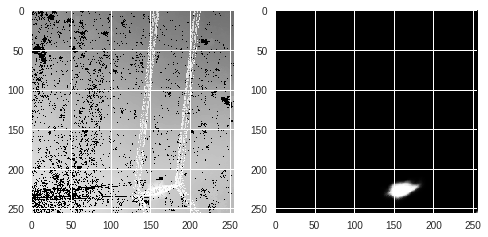

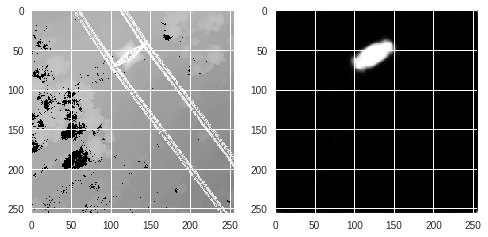

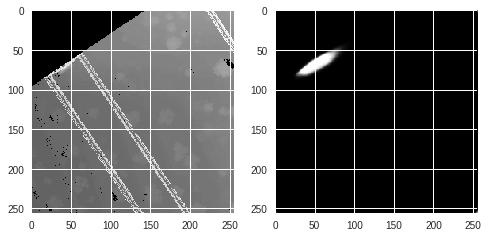

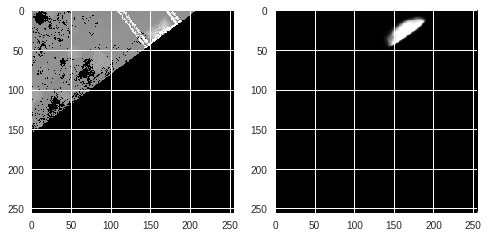

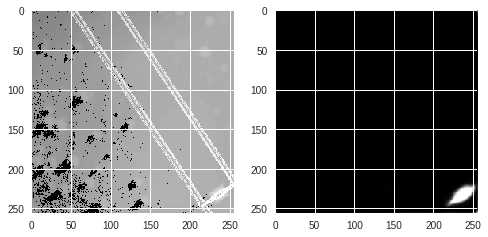

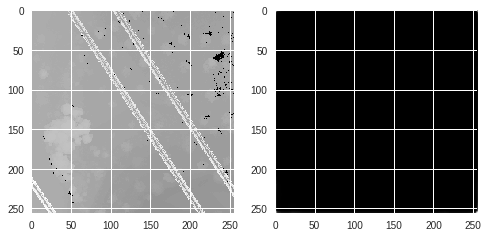

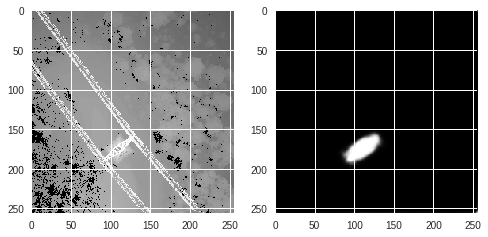

In [0]:
model = unet(pretrained_weights="unet_turret.hdf5",input_size = (256,256,1))
test_model(model, n_images=20)
  

**Even sharper results**

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


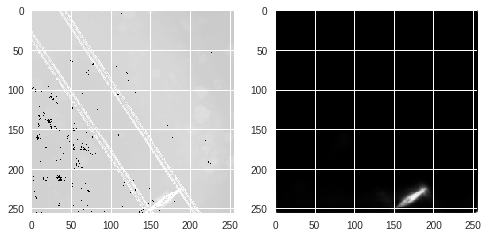

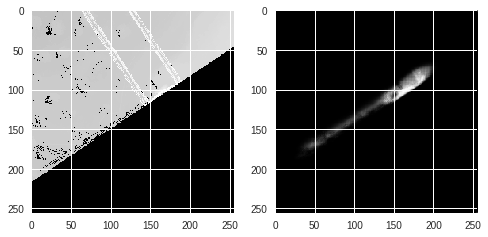

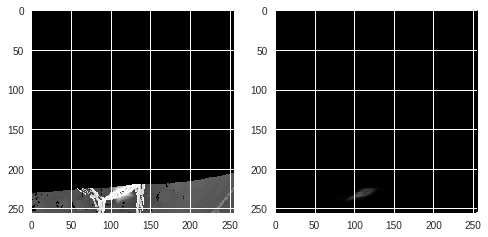

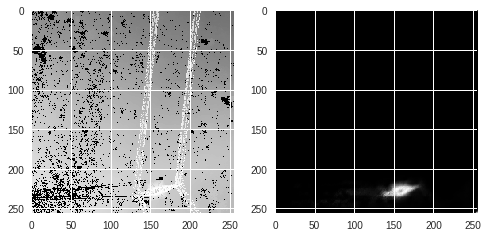

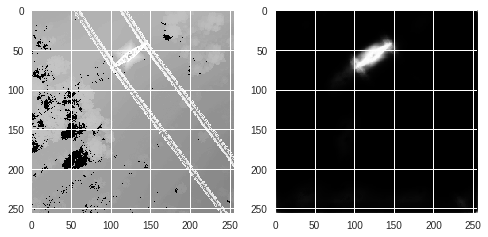

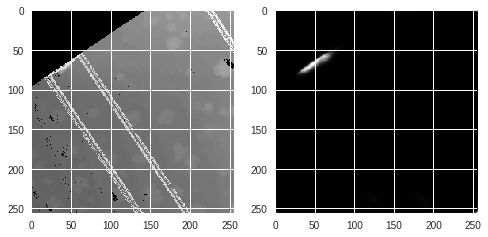

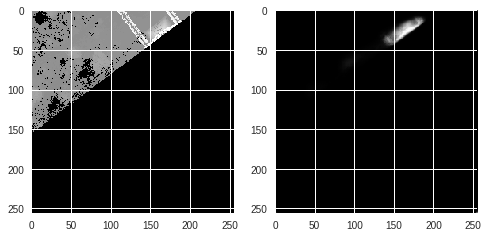

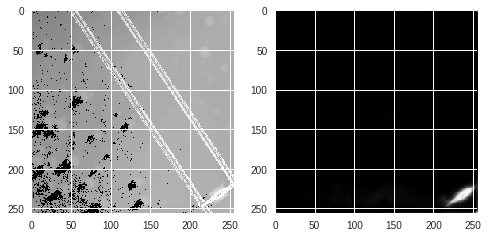

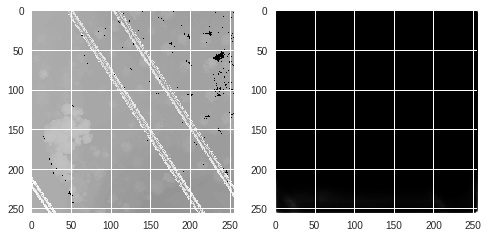

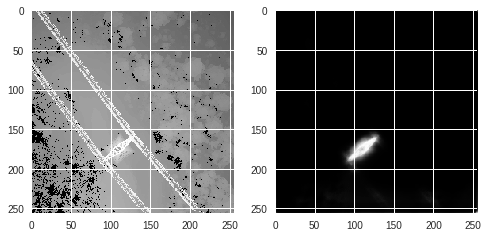

In [0]:
model = unet(pretrained_weights="unet_turret.hdf5",input_size = (256,256,1))
testModel(model=model, n_images=10)

## Segmenting the whole map

Predicting


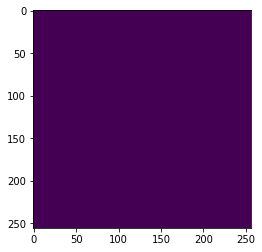

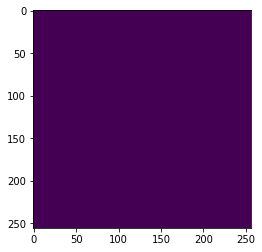

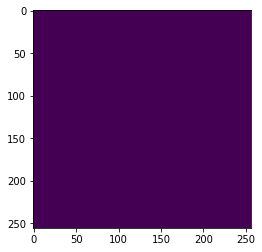

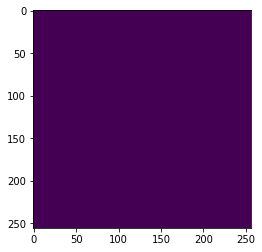

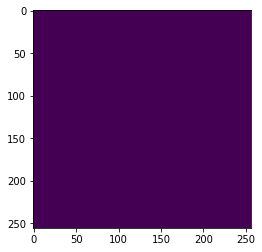

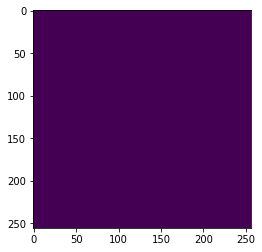

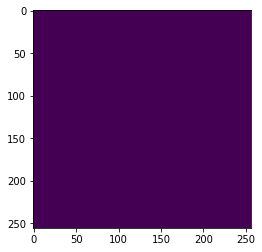

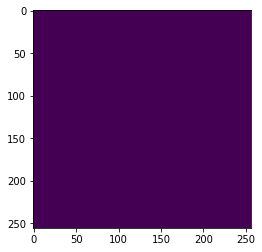

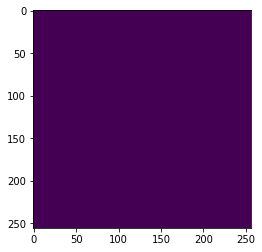

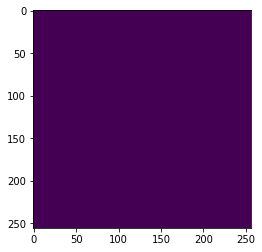

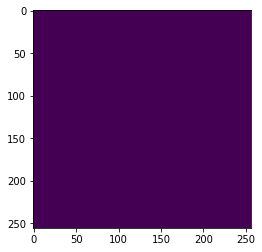

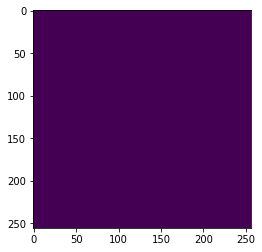

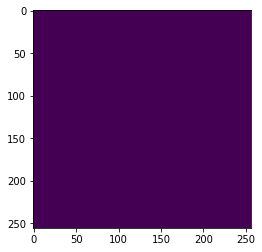

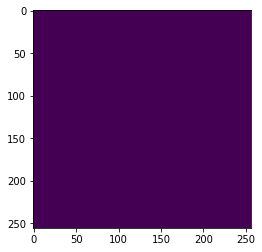

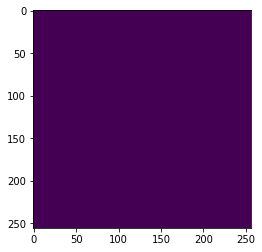

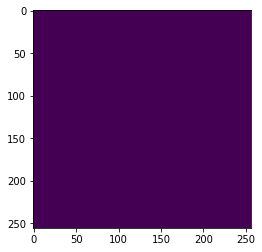

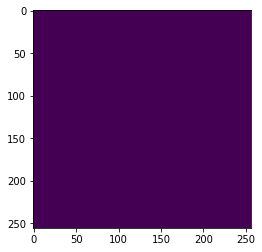

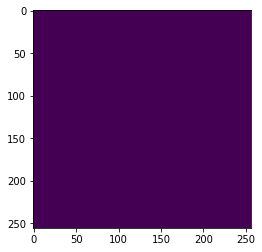

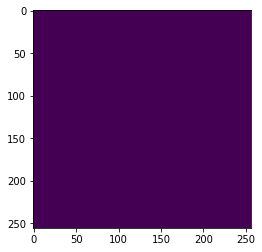

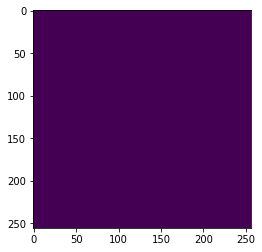

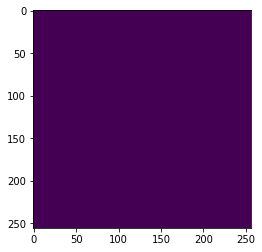

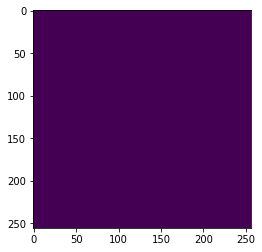

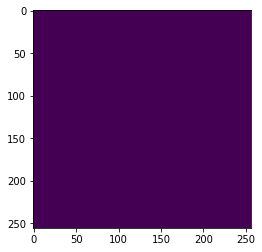

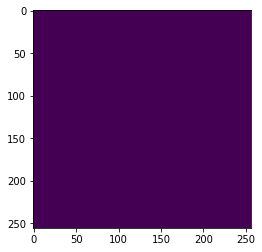

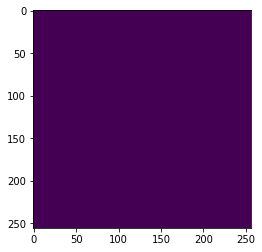

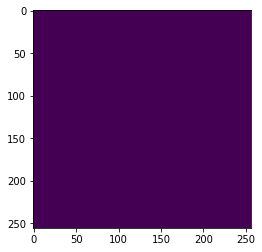

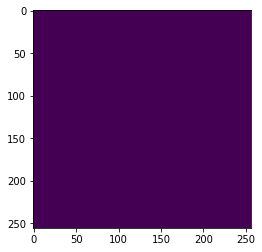

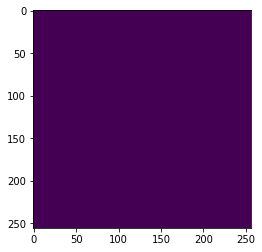

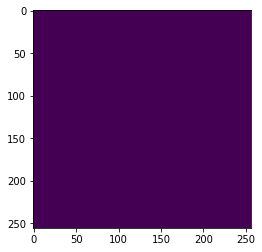

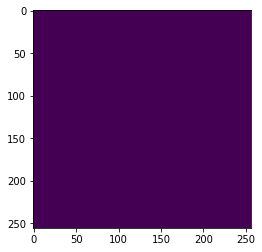

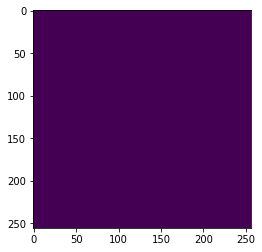

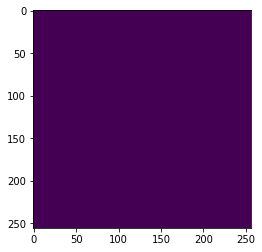

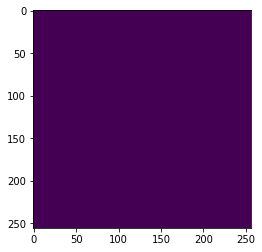

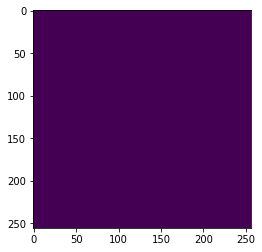

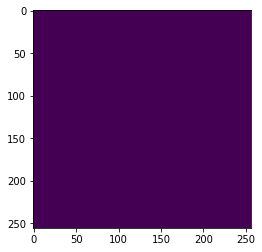

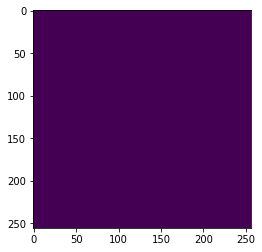

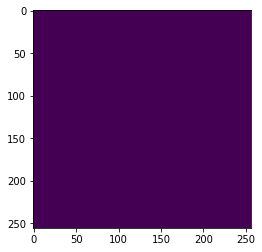

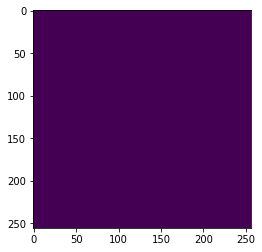

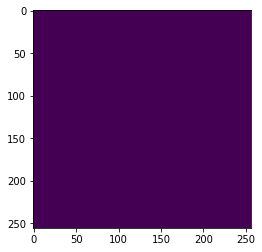

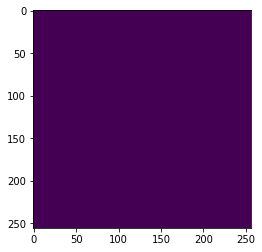

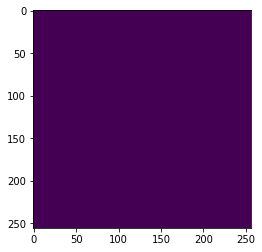

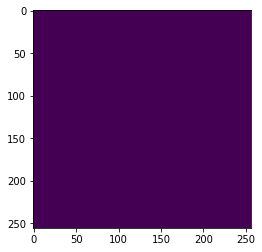

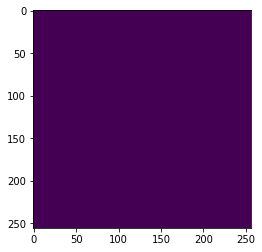

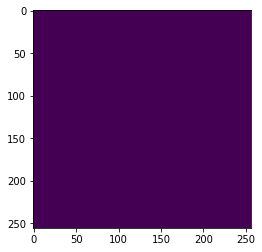

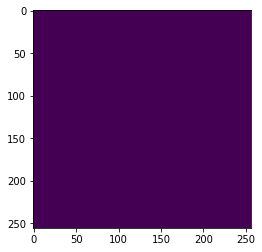

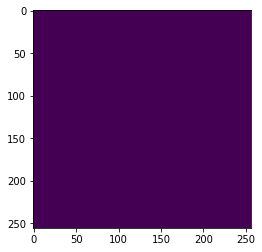

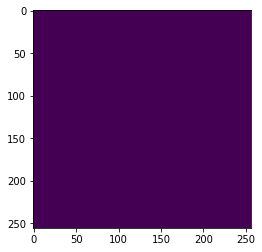

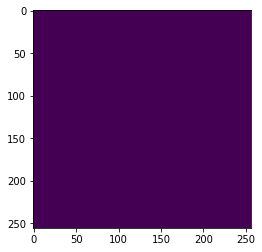

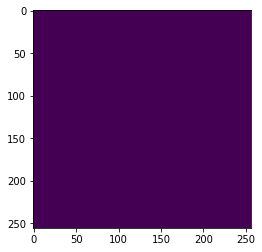

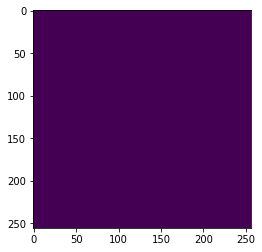

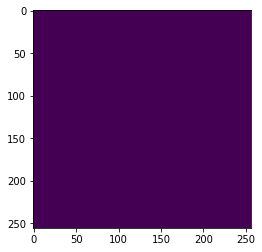

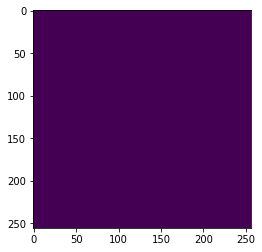

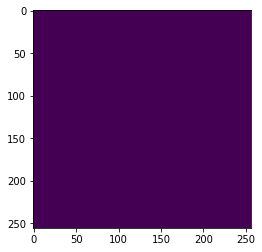

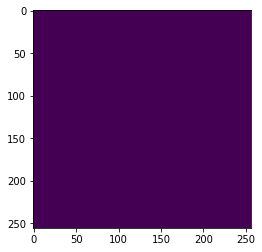

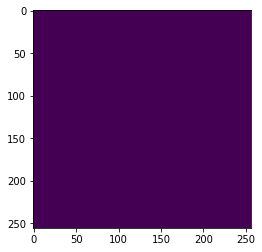

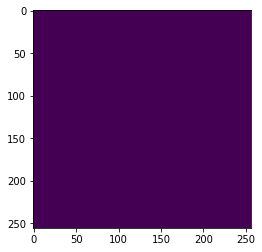

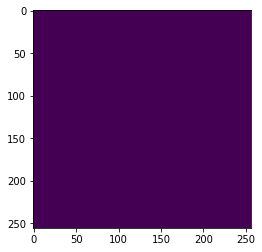

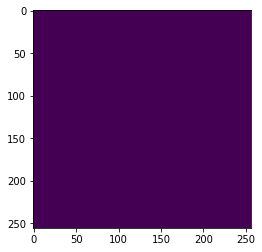

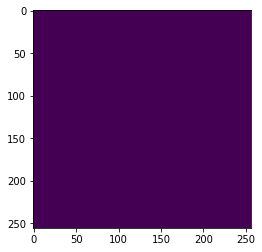

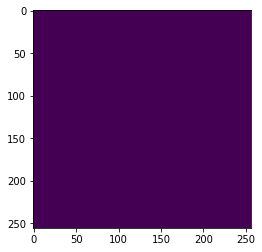

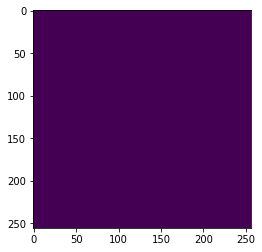

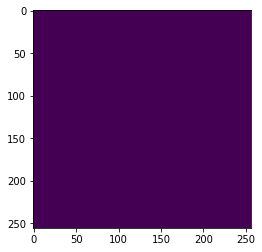

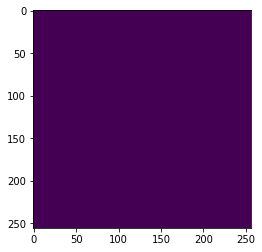

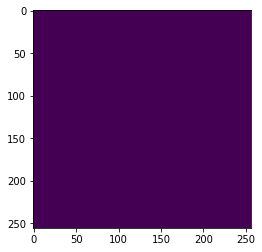

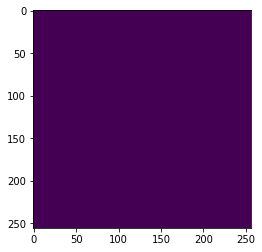

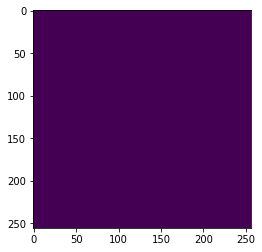

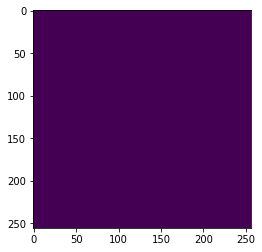

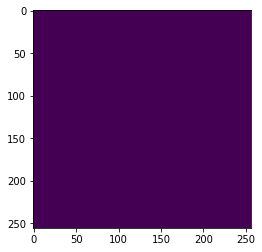

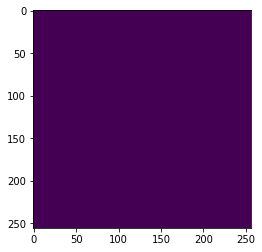

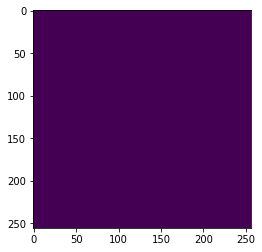

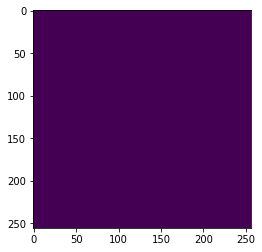

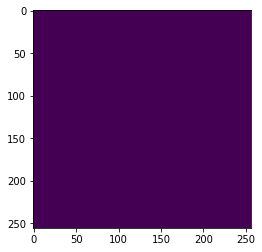

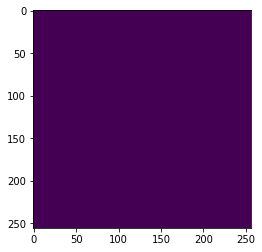

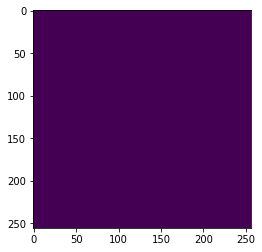

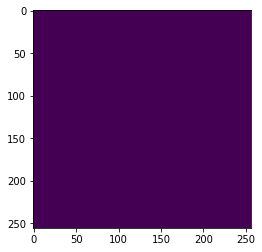

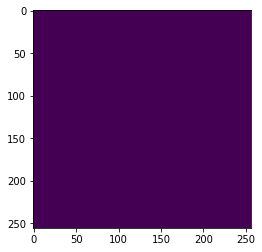

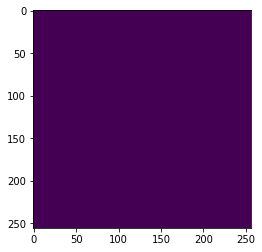

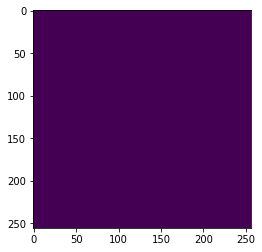

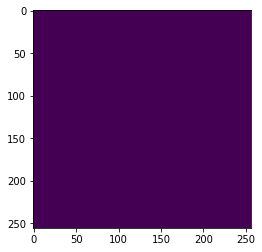

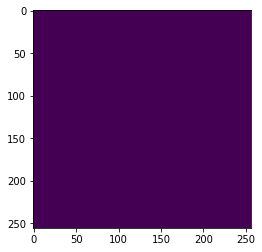

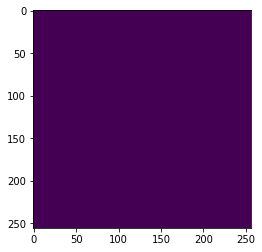

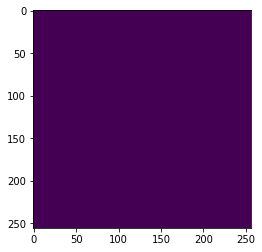

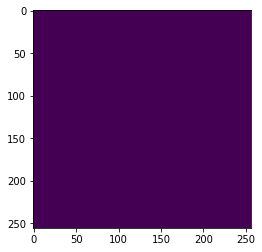

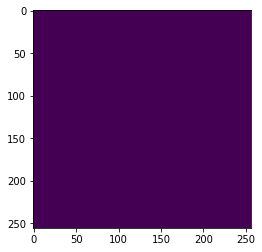

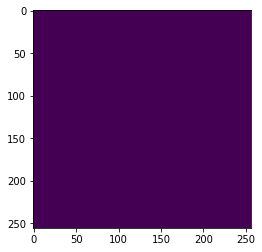

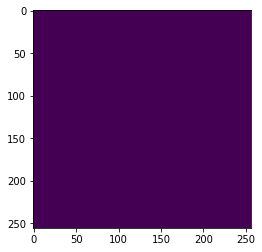

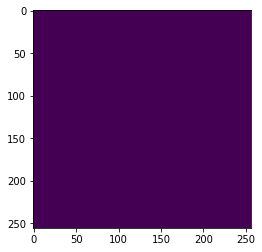

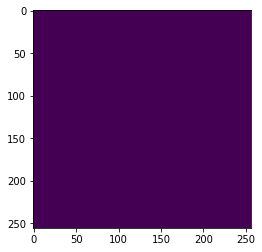

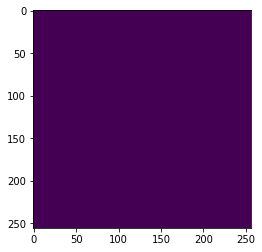

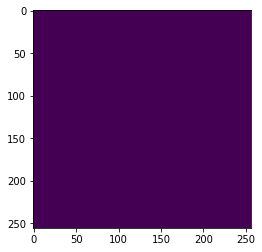

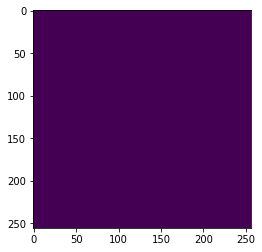

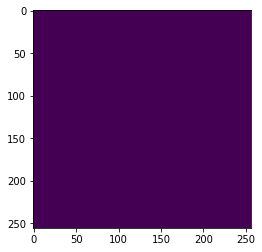

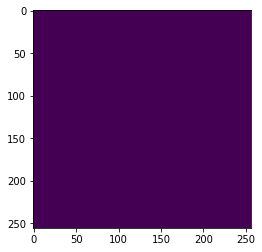

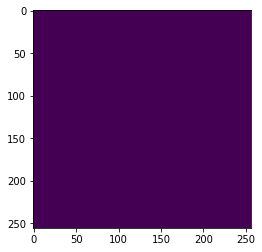

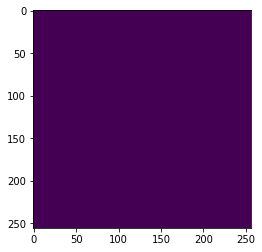

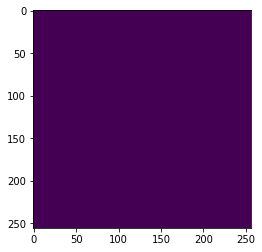

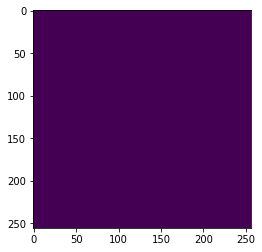

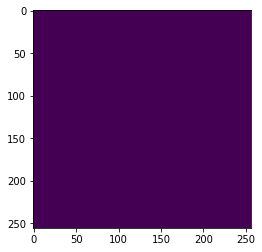

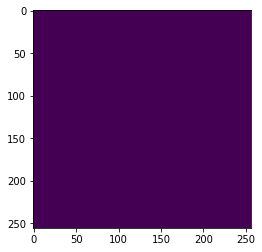

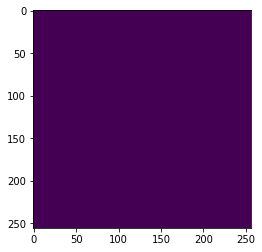

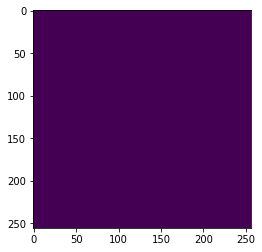

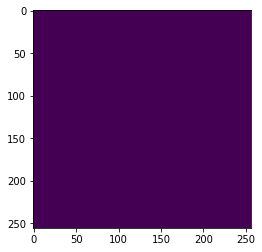

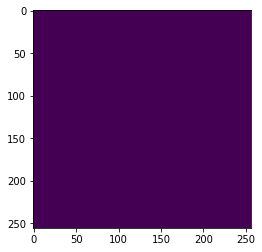

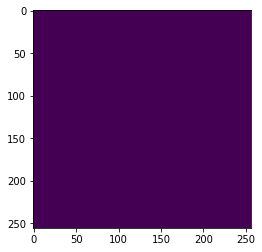

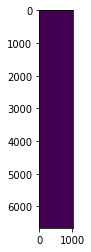

In [0]:
def predict_map(model, image, tile_size=(256,256)):
  w = image.shape[0]
  h = image.shape[1]
  n_channels = 1
  
  n_images = 10
  
  xs = range(0, w, tile_size[0])
  ys = range(0, h, tile_size[1])
  
  tiles = np.zeros((len(xs) * len(ys), tile_size[0], tile_size[1], n_channels))
  
  i = 0
  for x in xs: 
    for y in ys:
      t = image[x: x+tile_size[0], 
                   y: y+tile_size[1], 
                   0:1]  #Just first channel now
      
      t = add_padding_zeros(t, tile_size)
      
      tiles[i,:,:] = t
      i = i +1
  
  print("Predicting")
  p = model.predict(tiles)
  
  prediction_map = np.zeros((len(xs)* tile_size[0], len(ys) * tile_size[1]), dtype=float)
  
  i = 0
  for x in xs: 
    for y in ys:
      tile_pred = p[i, :, :]
      show_image(tile_pred.reshape((256,256)))
      prediction_map[x:x+tile_size[0],y:y+tile_size[1]] = p[i, :, :].reshape((tile_size[0], tile_size[1]))

  return prediction_map

mat = scipy.io.loadmat(heightmap_matfile)
#model = unet(pretrained_weights="unet_turret.hdf5")
p_map = predict_map(model_gen,  image=mat["feat_img"], tile_size=(256,256))

show_image(p_map)


In [0]:
print(np.unique(p_map))

[0.49502751]
